In [292]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import numpy as np
import cv2
import imghdr

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [173]:
#Do I even have a GPU?
gpus = tf.config.experimental.list_physical_devices('GPU')
print(len(gpus))
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

0


In [174]:
data_dir = 'img_classifier'
img_exts = ['jpeg', 'jpg', 'png', 'bmp']
for img_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, img_class)):
        img_path = os.path.join(data_dir, img_class, image)       
        try:
            img = cv2.imread(image_path)
            if not img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                print( 'Image not in extension list: {}'.format(img_path))
                os.remove(img_path)
        except Exception as e:
            print('Issue with image {}'.format(img_path))
            os.remove(img_path)

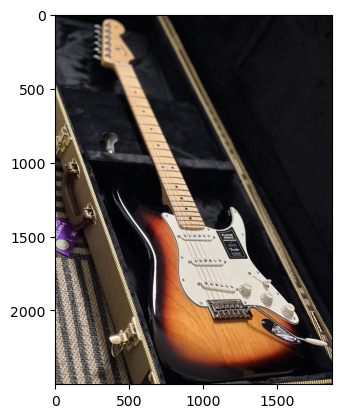

In [270]:
img = cv2.imread(os.path.join(data_dir, 'strat','img_3642-ql8jr599a5.jpg'))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [178]:
data = tf.keras.utils.image_dataset_from_directory('img_classifier')

Found 161 files belonging to 2 classes.


In [189]:
data_iterator = data.as_numpy_iterator()

In [190]:
batch = data_iterator.next()

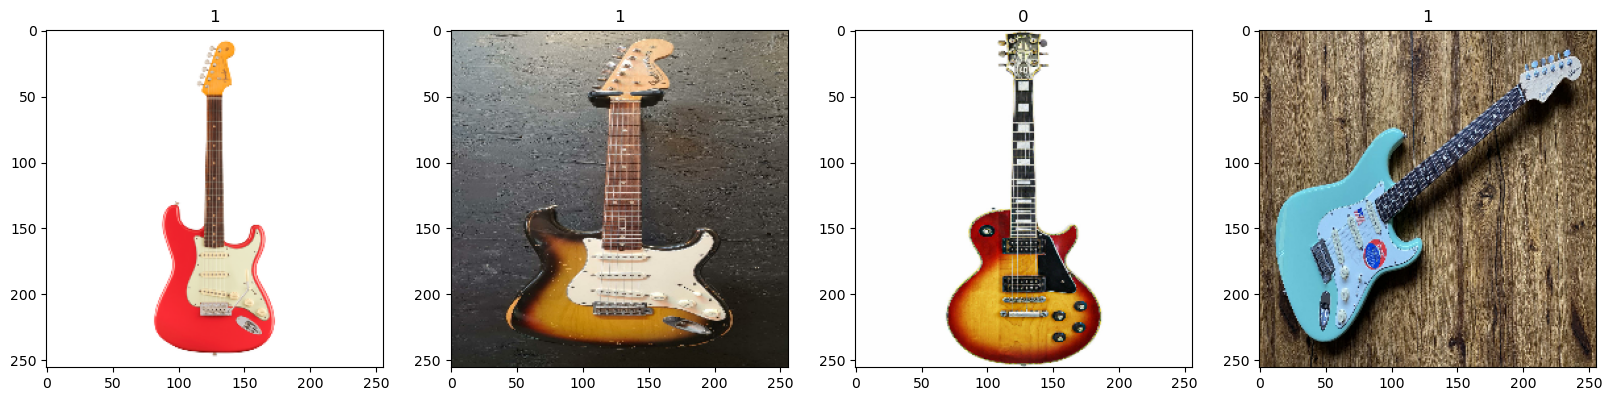

In [191]:
fig, ax = plt.subplots(ncols = 4)
fig.set_size_inches(20, 20)
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [192]:
#class 0 = Gibson Les Paul
#class 1 = Fender Stratocaster

In [193]:
#Scaling RGB values to the interval [0,1]
data = data.map(lambda x,y: (x/255,y))

In [194]:
len(data)

6

In [195]:
# Typical valus: train 70%, validate 20%, test 10%
train_size = 4
val_size = 1
test_size = 1

In [196]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [197]:
model = Sequential()
#Conv2D(num_filters=16, window_size=(3,3), window_displacement=1)
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [198]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [199]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [200]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5635 - loss: 1.3782 - val_accuracy: 0.5000 - val_loss: 0.7807
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5021 - loss: 0.7756 - val_accuracy: 0.3438 - val_loss: 0.7768
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5875 - loss: 0.6456 - val_accuracy: 0.7188 - val_loss: 0.5834
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7229 - loss: 0.5898 - val_accuracy: 0.8125 - val_loss: 0.4732
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8052 - loss: 0.4757 - val_accuracy: 0.8750 - val_loss: 0.3791
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8781 - loss: 0.3629 - val_accuracy: 0.8750 - val_loss: 0.3128
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8646 - loss: 0.3045 - val_accuracy: 0.9062 - val_loss: 0.2463
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9260 - loss: 0.2520 - val_accuracy: 0.9375 - val_loss: 0.1832
Epoch 9/20
4/4 

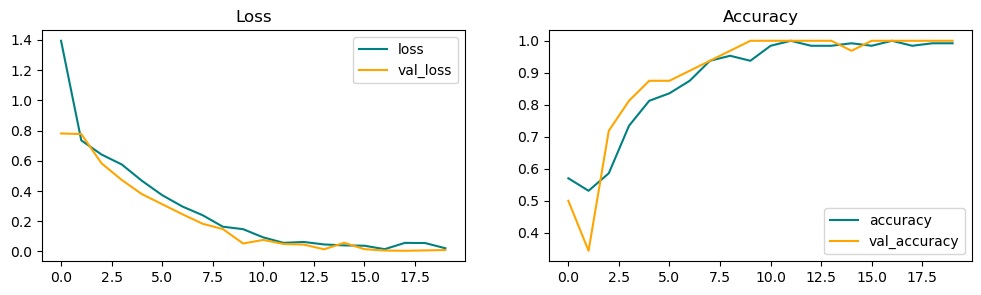

In [229]:
fig1, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val_loss')
ax[0].title.set_text('Loss')
ax[0].legend(loc='upper right')

ax[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
ax[1].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
ax[1].legend(loc='lower right')
ax[1].title.set_text('Accuracy')
plt.show()

In [231]:
prec = Precision()
rec = Recall()
binacc = BinaryAccuracy()

In [259]:
for batch in test.as_numpy_iterator():
    X,y = batch
    y_hat = model.predict(X)
    prec.update_state(y, y_hat)
    rec.update_state(y, y_hat)
    binacc.update_state(y, y_hat)
print(f'Precision:{prec.result()}.    Recall:{rec.result()}.    Binary Accuracy:{binacc.result()}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Precision:1.0.    Recall:1.0.    Binary Accuracy:1.0


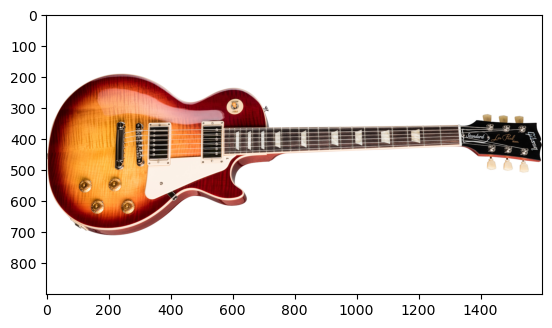

In [288]:
img = cv2.imread(os.path.join('test_pics','test_pic5.png'))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [289]:
resize = tf.image.resize(img, (256,256))
yhat = model.predict(np.expand_dims(resize/255,0))
if yhat > 0.5:
    print('This is a Stratocaster!')
else:
    print('This is a Les Paul!')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
This is a Les Paul!


In [293]:
model.save(os.path.join('models', 'guitarclassifier.h5'))

In [294]:
new_model = load_model(os.path.join('models', 'guitarclassifier.h5'))

In [295]:
yhat2 = new_model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
